In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization
from keras.layers.noise import GaussianNoise
from keras.utils import np_utils
from keras import backend as K

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import confusion_matrix
import itertools

In [11]:
img_width, img_height = 150, 150

# Global variables that are directory specific
train_data_dir = 'data-without-aug/train/'
validation_data_dir = 'data-without-aug/validation/'
nb_train_samples = 7285
nb_validation_samples = 2602
epochs = 1
batch_size = 32

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [12]:

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
train_datagen = ImageDataGenerator(
    rotation_range=360,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Testing Augmentation Configuration
# Only Rescales images
# Very important for the validation data to have no augmentation
# Enables validation on real data, and not augmented data
test_datagen = ImageDataGenerator(
    rescale=1. / 255
)


In [14]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# VALIDATION GENERATOR
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

# MODEL FITTING
fit = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    shuffle=True)

# SAVE MODEL (INCLUDING WEIGHTS)
model.save('first_try.h5')

Found 7285 images belonging to 7 classes.
Found 2602 images belonging to 7 classes.
Epoch 1/1
227/227 [==============================] - 287s 1s/step - loss: 1.1539 - acc: 0.6752 - val_loss: 1.0510 - val_acc: 0.6647


Variance PCA: 1.0
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.000059
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.337082
[t-SNE] Error after 1000 iterations: 0.290979


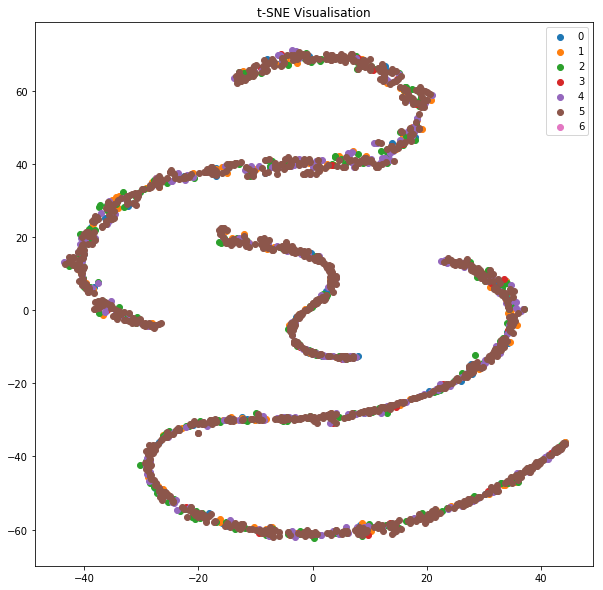

In [17]:
# TSNE VISUALISATION

predictions = model.predict_generator(validation_generator,
                                          steps=nb_validation_samples)

# First, reduce to 7 dimensions with PCA
pca = PCA(n_components=7)
pca_results = pca.fit_transform(predictions)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

# Next, run t-SNE on the PCA results to obtain a 2D plot
tsne = TSNE(n_components=2, perplexity=30, learning_rate=250, verbose = 1)
tsne_results = tsne.fit_transform(pca_results[:2000])

# Convert to binary class matrix
categoricalClasses = np_utils.to_categorical(validation_generator.classes[:2000], num_classes = 7)
# Create a figure where each class has a unique colour
colour_map = np.argmax(categoricalClasses, axis=1)
tsneFigure = plt.figure(figsize=(10,10))
for colour in range(7):
    indices = np.where(colour_map==colour)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0],
                tsne_results[indices,1],
                label=colour)
plt.legend()
plt.title('t-SNE Visualisation')
tsneFigure.savefig('tsneVisualisation.jpg')
plt.show()
plt.close()

Variance PCA: 1.0
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 82582 samples in 0.053s...
[t-SNE] Computed neighbors for 82582 samples in 1.264s...
[t-SNE] Computed conditional probabilities for sample 1000 / 82582
[t-SNE] Computed conditional probabilities for sample 2000 / 82582
[t-SNE] Computed conditional probabilities for sample 3000 / 82582
[t-SNE] Computed conditional probabilities for sample 4000 / 82582
[t-SNE] Computed conditional probabilities for sample 5000 / 82582
[t-SNE] Computed conditional probabilities for sample 6000 / 82582
[t-SNE] Computed conditional probabilities for sample 7000 / 82582
[t-SNE] Computed conditional probabilities for sample 8000 / 82582
[t-SNE] Computed conditional probabilities for sample 9000 / 82582
[t-SNE] Computed conditional probabilities for sample 10000 / 82582
[t-SNE] Computed conditional probabilities for sample 11000 / 82582
[t-SNE] Computed conditional probabilities for sample 12000 / 82582
[t-SNE] Computed conditional pro

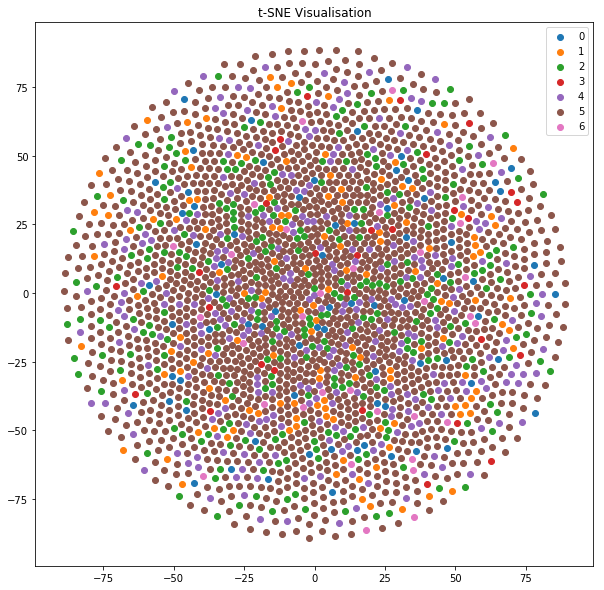

In [18]:
# TSNE VISUALISATION

predictions = model.predict_generator(validation_generator,
                                          steps=nb_validation_samples)

# First, reduce to 7 dimensions with PCA
pca = PCA(n_components=7)
pca_results = pca.fit_transform(predictions)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

# Next, run t-SNE on the PCA results to obtain a 2D plot
tsne = TSNE(n_components=2, perplexity=30, learning_rate=250, verbose = 1)
tsne_results = tsne.fit_transform(pca_results)

# Convert to binary class matrix
categoricalClasses = np_utils.to_categorical(validation_generator.classes, num_classes = 7)
# Create a figure where each class has a unique colour
colour_map = np.argmax(categoricalClasses, axis=1)
tsneFigure = plt.figure(figsize=(10,10))
for colour in range(7):
    indices = np.where(colour_map==colour)
    indices = indices[0]
    plt.scatter(tsne_results[indices,0],
                tsne_results[indices,1],
                label=colour)
plt.legend()
plt.title('t-SNE Visualisation')
tsneFigure.savefig('tsneVisualisation2.jpg')
plt.show()
plt.close()